In [1]:
#!/usr/bin/env python3
import os
import cv2
import numpy as np
from PIL import Image, ExifTags
import random
import matplotlib.pyplot as plt

# ------------------------------
# Utility to extract focal length from EXIF
# ------------------------------
def get_focal_length(image_path):
    try:
        img = Image.open(image_path)
        exif = img._getexif()
        if exif is not None:
            # The tag for focal length can vary – we try to lookup by name
            for tag, value in exif.items():
                decoded = ExifTags.TAGS.get(tag, tag)
                if decoded == 'FocalLength':
                    # Value can be a ratio like (f, 1) or a tuple (numerator, denominator)
                    if isinstance(value, tuple) and len(value) == 2:
                        focal = float(value[0]) / float(value[1])
                        return focal
                    else:
                        return float(value)
    except Exception as e:
        print(f"Error reading EXIF from {image_path}: {e}")
    return None

# ------------------------------
# SIFT Feature Extraction using OpenCV
# ------------------------------
def compute_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Unable to load image: {image_path}")
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# ------------------------------
# FLANN-based feature matching between two images
# ------------------------------
def match_features(desc1, desc2, ratio_thresh=0.4):
    # FLANN parameters for SIFT (uses kd-tree)
    index_params = dict(algorithm=1, trees=5)  # algorithm=1 for kd-tree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    
    # Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    return good_matches

# ------------------------------
# Simple union-find (disjoint set) structure for track merging
# ------------------------------
class UnionFind:
    def __init__(self):
        self.parent = {}

    def find(self, item):
        # Path compression
        if self.parent[item] != item:
            self.parent[item] = self.find(self.parent[item])
        return self.parent[item]

    def union(self, item1, item2):
        root1 = self.find(item1)
        root2 = self.find(item2)
        if root1 != root2:
            self.parent[root2] = root1

    def add(self, item):
        if item not in self.parent:
            self.parent[item] = item

# ------------------------------
# Build tracks from pairwise matches
# ------------------------------
def build_tracks(image_features, pairwise_matches, min_track_length=2):
    """
    image_features: dict mapping image index to (keypoints, descriptors)
    pairwise_matches: list of tuples (i, j, matches) where matches is a list of cv2.DMatch objects
                      between image i and j.
    """
    uf = UnionFind()
    # Assign unique ids to each feature in each image: (img_idx, kp_idx)
    for img_idx, (kps, _) in image_features.items():
        for kp_idx in range(len(kps)):
            uf.add((img_idx, kp_idx))
    
    # For each pair, union the matched keypoints
    for (i, j, matches) in pairwise_matches:
        for m in matches:
            feat_i = (i, m.queryIdx)
            feat_j = (j, m.trainIdx)
            uf.union(feat_i, feat_j)

    # Group features by track (root of union-find)
    tracks = {}
    for img_idx, (kps, _) in image_features.items():
        for kp_idx, kp in enumerate(kps):
            root = uf.find((img_idx, kp_idx))
            if root not in tracks:
                tracks[root] = []
            tracks[root].append((img_idx, kp_idx, kp.pt))
    
    # Filter out short tracks
    filtered_tracks = {k: v for k, v in tracks.items() if len(set(x[0] for x in v)) >= min_track_length}
    return filtered_tracks

# ------------------------------
# Placeholder bundle adjustment function
# ------------------------------
def bundle_adjustment(tracks, image_features, focal_lengths):
    """
    This function is a placeholder. A full implementation would optimize the camera poses and 3D point locations.
    For now, we simulate the process by generating dummy camera poses and 3D points.
    """
    num_images = len(image_features)
    # Simulate camera poses as identity matrices (4x4)
    camera_poses = {img_idx: np.eye(4) for img_idx in image_features.keys()}
    
    # Simulate 3D points by averaging back-projected 2D track points.
    # (In a real system, you would use triangulation and BA here.)
    points3D = []
    for track in tracks.values():
        pts = np.array([pt for (_, _, pt) in track])
        # Dummy 3D point: (mean_x, mean_y, random depth)
        mean_pt = np.mean(pts, axis=0)
        depth = np.random.uniform(5, 15)  # random depth
        point3D = np.array([mean_pt[0], mean_pt[1], depth])
        points3D.append(point3D)
    return camera_poses, points3D

# ------------------------------
# Write out bundle file and PLY file
# ------------------------------
def write_bundle_file(bundle_path, camera_poses, points3D):
    with open(bundle_path, 'w') as f:
        f.write("# Bundle file placeholder\n")
        f.write(f"{len(camera_poses)} {len(points3D)}\n")
        # Write dummy focal lengths and distortions (for each camera)
        for cam_idx in sorted(camera_poses.keys()):
            focal = 1.0  # dummy value; in a real system, use actual focal length
            k1 = k2 = 0.0
            f.write(f"{focal} {k1} {k2}\n")
            # Write the 3x3 rotation matrix (from the 4x4 pose) and translation vector
            pose = camera_poses[cam_idx]
            R = pose[:3, :3].flatten()
            t = pose[:3, 3]
            f.write(" ".join(map(str, R)) + "\n")
            f.write(" ".join(map(str, t)) + "\n")
        # Write 3D points (dummy RGB values)
        for pt in points3D:
            f.write(" ".join(map(str, pt)) + " 255 255 255\n")
    print(f"Bundle file written to {bundle_path}")

def write_ply_file(ply_path, camera_poses, points3D):
    with open(ply_path, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        num_vertices = len(points3D) + len(camera_poses)
        f.write(f"element vertex {num_vertices}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        # Write camera centers (in red)
        for pose in camera_poses.values():
            # Camera center can be computed from the inverse of rotation and translation.
            R = pose[:3, :3]
            t = pose[:3, 3]
            cam_center = -R.T @ t
            f.write(f"{cam_center[0]} {cam_center[1]} {cam_center[2]} 255 0 0\n")
        # Write 3D points (in white)
        for pt in points3D:
            f.write(f"{pt[0]} {pt[1]} {pt[2]} 255 255 255\n")
    print(f"PLY file written to {ply_path}")

# ------------------------------
# Main pipeline
# ------------------------------
def main(image_dir):
    # Get list of jpg images in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
    image_files.sort()  # sort for reproducibility

    # Optionally sample images (example: if you have many images and only want a subset)
    if len(image_files) > 10:
        random.seed(40)  # set a fixed seed for reproducibility
        image_files = random.sample(image_files, 10)
        image_files.sort()

    image_features = {}
    focal_lengths = {}
    print("Extracting EXIF focal lengths and computing SIFT features...")
    for idx, fname in enumerate(image_files):
        path = os.path.join(image_dir, fname)
        focal = get_focal_length(path)
        focal_lengths[idx] = focal if focal is not None else 1.0  # default focal if missing
        kps, desc = compute_sift_features(path)
        image_features[idx] = (kps, desc)
        print(f"Image {fname}: {len(kps)} keypoints, focal length = {focal_lengths[idx]}")
    
    # Pairwise feature matching
    pairwise_matches = []
    num_images = len(image_files)
    print("Performing pairwise feature matching...")
    for i in range(num_images):
        for j in range(i+1, num_images):
            kps1, desc1 = image_features[i]
            kps2, desc2 = image_features[j]
            if desc1 is None or desc2 is None:
                continue
            matches = match_features(desc1, desc2)
            print(f"Matched Image {i} and {j}: {len(matches)} good matches")
            if len(matches) > 10:  # threshold to consider valid matching
                pairwise_matches.append((i, j, matches))
    
    # -------------------------------------------------------
    # Visualization of keypoints and matches for the first pair (optional)
    # -------------------------------------------------------
    if pairwise_matches:
        # Take the first valid pair for demonstration
        i, j, matches = pairwise_matches[0]
        
        # Load the corresponding images in color (for drawing)
        img1_path = os.path.join(image_dir, image_files[i])
        img2_path = os.path.join(image_dir, image_files[j])
        img1_color = cv2.imread(img1_path, cv2.IMREAD_COLOR)
        img2_color = cv2.imread(img2_path, cv2.IMREAD_COLOR)
        
        kps1, desc1 = image_features[i]
        kps2, desc2 = image_features[j]

        # Draw the keypoints on each image
        img1_kp = cv2.drawKeypoints(img1_color, kps1, None,
                                    color=(0, 255, 255),
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        img2_kp = cv2.drawKeypoints(img2_color, kps2, None,
                                    color=(0, 255, 255),
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Show the keypoints on each image side by side
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"Keypoints in Image {i} ({image_files[i]})")
        plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Keypoints in Image {j} ({image_files[j]})")
        plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Draw the matches between the two images
        matched_image = cv2.drawMatches(
            img1_color, kps1,
            img2_color, kps2,
            matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        
        plt.figure(figsize=(12, 6))
        plt.title(f"Feature Matches between Image {i} and {j}")
        plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("No valid image pairs to visualize (no matches found).")

    # Build tracks across images using union-find on matches
    print("Building feature tracks...")
    tracks = build_tracks(image_features, pairwise_matches, min_track_length=2)
    print(f"Number of tracks found: {len(tracks)}")
    
    # (Optionally, here you could discard inconsistent tracks based on geometry)
    
    # Run sparse bundle adjustment (placeholder)
    print("Running bundle adjustment (placeholder)...")
    camera_poses, points3D = bundle_adjustment(tracks, image_features, focal_lengths)
    
    # Write output files
    write_bundle_file("bundle.out", camera_poses, points3D)
    write_ply_file("reconstruction.ply", camera_poses, points3D)
    print("Reconstruction complete.")



Extracting EXIF focal lengths and computing SIFT features...
Image 13012027@N04_2073427575.rd.jpg: 5017 keypoints, focal length = 1.0
Image 7368078@N04_423060766.jpg: 5781 keypoints, focal length = 1.0
Performing pairwise feature matching...
Matched Image 0 and 1: 683 good matches


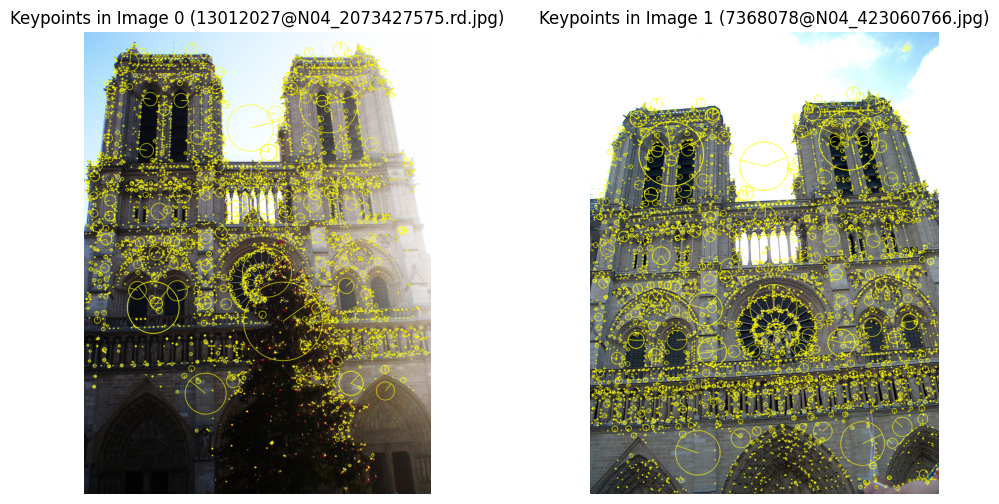

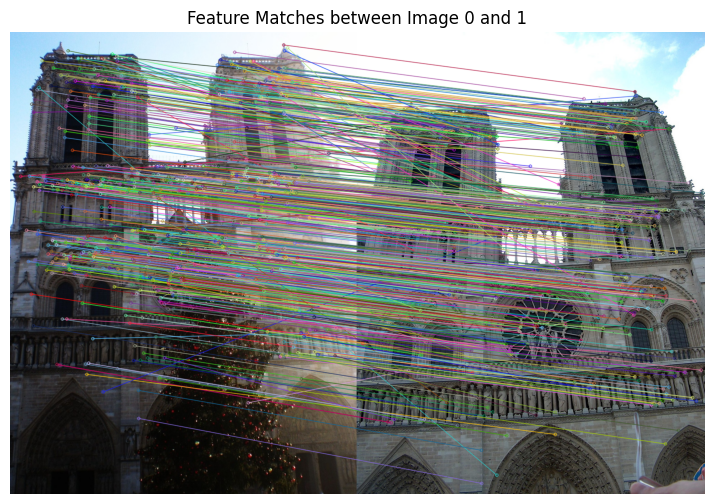

Building feature tracks...
Number of tracks found: 636
Running bundle adjustment (placeholder)...
Bundle file written to bundle.out
PLY file written to reconstruction.ply
Reconstruction complete.


In [3]:
if __name__ == "__main__":
    # Specify the directory containing your images
    image_directory = "Imagetest"  # Update with your actual path
    main(image_directory)

In [4]:
#!/usr/bin/env python3

import os
import cv2
import numpy as np
from PIL import Image, ExifTags
import glob

# ----------------------------------------------------
# 1) Utility functions
# ----------------------------------------------------

def get_focal_length(image_path):
    """
    Extracts the focal length (in pixels) from EXIF data if available.
    Returns None if unavailable.
    """
    try:
        img = Image.open(image_path)
        exif = img._getexif()
        if exif is not None:
            for tag, value in exif.items():
                decoded = ExifTags.TAGS.get(tag, tag)
                if decoded == 'FocalLength':
                    # value can be (num, den)
                    if isinstance(value, tuple) and len(value) == 2:
                        return float(value[0]) / float(value[1])
                    else:
                        return float(value)
    except:
        pass
    return None

def build_intrinsics(image_path, focal_override=None):
    """
    Builds a 3x3 camera intrinsic matrix using:
    - focal length from EXIF (in mm) and approximate sensor width,
      or a user-provided override (in pixels).
    - principal point at the image center.
    In a real pipeline, you'd also handle sensor size to convert mm -> pixels properly.
    """
    # Load image just to get shape
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape[:2]

    # Approx: if we have an EXIF focal in mm, we typically need to convert to pixel units:
    # focal_pixels = (f_mm / sensor_width_mm) * image_width_in_pixels
    # For simplicity, we just take the user override or fallback to a fixed guess
    if focal_override is not None:
        f = focal_override
    else:
        f_exif = get_focal_length(image_path)
        if f_exif is not None:
            # This is usually in mm, but let's pretend it's in pixels for simplicity
            # Real code should convert mm -> pixels if sensor size is known.
            f = f_exif
        else:
            # fallback if EXIF not found
            f = 0.9 * w  # just a rough guess

    cx = w / 2.0
    cy = h / 2.0

    K = np.array([
        [f,   0,  cx],
        [0,   f,  cy],
        [0,   0,   1]
    ], dtype=np.float64)
    return K, (w, h)

def extract_features(image_path):
    """
    Extracts SIFT keypoints and descriptors from an image.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise IOError(f"Cannot load image: {image_path}")
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

def match_features(desc1, desc2, ratio_thresh=0.75):
    """
    Matches two sets of SIFT descriptors using FLANN + Lowe's ratio test.
    Returns a list of good matches.
    """
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    knn = flann.knnMatch(desc1, desc2, k=2)

    good = []
    for m, n in knn:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)
    return good

def pose_from_essential(kps1, kps2, K, matches):
    """
    Given matched keypoints in two images and the camera intrinsics K,
    estimate the essential matrix (via RANSAC) and recover the relative pose (R, t).
    Returns R, t, and inlier matches.
    """
    # Convert keypoints to numpy arrays of shape (N, 2)
    pts1 = np.float32([kps1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kps2[m.trainIdx].pt for m in matches])

    # Normalize by K if desired, or just use findEssentialMat with K
    E, mask = cv2.findEssentialMat(pts1, pts2, K,
                                   method=cv2.RANSAC, prob=0.999, threshold=1.0)
    # mask is an inlier/outlier mask for each match
    inliers = mask.ravel().tolist()

    # Recover pose from E
    # Note: returns 3x3 R, 3x1 t
    _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K, mask=mask)
    inliers_pose = mask_pose.ravel().tolist()

    # We'll combine them so only matches that are inliers in the final pose remain
    # but in practice, findEssentialMat's mask and recoverPose's mask often coincide
    inlier_matches = []
    for match_i, (m, inlE, inlP) in enumerate(zip(matches, inliers, inliers_pose)):
        if inlE and inlP:
            inlier_matches.append(m)

    return R, t, inlier_matches

def triangulate_points(kps1, kps2, K, R1, t1, R2, t2, matches):
    """
    Triangulate 3D points given matched keypoints between two views (R1,t1) and (R2,t2).
    Returns Nx3 array of 3D points in the coordinate system of the first camera.
    """
    # Build projection matrices P1, P2 in homogeneous coords
    #   P = K * [R|t]
    P1 = K @ np.hstack((R1, t1))
    P2 = K @ np.hstack((R2, t2))

    pts1 = np.float32([kps1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kps2[m.trainIdx].pt for m in matches])

    # Triangulate in homogeneous coordinates
    pts4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

    # Convert from homogeneous to 3D
    pts4d = (pts4d_hom / pts4d_hom[3])[:3].T  # shape (N,3)
    return pts4d

def get_camera_center(R, t):
    """
    Given a camera pose [R|t], the center C is -R^T t in world coordinates.
    """
    return -R.T @ t

# ----------------------------------------------------
# 2) Main incremental pipeline
# ----------------------------------------------------
def incremental_sfm(image_dir, focal_override=None):
    """
    A minimal, incremental SfM pipeline:
      - Reads all images
      - For each consecutive pair, we estimate pose, triangulate points
      - For subsequent images, we do PnP to get the new pose, then triangulate new points
    NOTE: No loop closure or full BA, so results are likely approximate.
    """

    # 1. Gather images
    img_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    if len(img_paths) < 2:
        raise ValueError("Need at least two images for reconstruction.")

    # 2. Build intrinsics and extract features for each image
    all_K = []
    all_size = []
    all_keypoints = []
    all_descriptors = []
    for path in img_paths:
        K, size = build_intrinsics(path, focal_override)
        all_K.append(K)
        all_size.append(size)
        kps, desc = extract_features(path)
        all_keypoints.append(kps)
        all_descriptors.append(desc)

    # We'll assume all images share the same intrinsics for simplicity
    # (If each image has different focal length from EXIF, you could store them separately.)
    K = all_K[0]

    # 3. Initialize with the first two images
    matches_01 = match_features(all_descriptors[0], all_descriptors[1])
    R1 = np.eye(3, dtype=np.float64)
    t1 = np.zeros((3,1), dtype=np.float64)  # world origin for first camera

    R2, t2, inliers_01 = pose_from_essential(
        all_keypoints[0], all_keypoints[1], K, matches_01
    )

    # Triangulate points between first two images
    pts3D_01 = triangulate_points(
        all_keypoints[0], all_keypoints[1], K,
        R1, t1, R2, t2, inliers_01
    )

    # Store camera poses
    camera_poses = [(R1, t1), (R2, t2)]
    # We'll store 3D points in a list (no merging across multiple views in this minimal example)
    global_points3D = pts3D_01.tolist()

    # 4. For each subsequent image i, match to the previous image (i-1)
    #    do solvePnP to estimate R,t, then triangulate new points
    for i in range(2, len(img_paths)):
        desc_i = all_descriptors[i]
        kps_i = all_keypoints[i]

        # Match with the previous image
        desc_prev = all_descriptors[i - 1]
        kps_prev = all_keypoints[i - 1]
        matches_i = match_features(desc_prev, desc_i)

        # Convert matches to 2D-3D pairs by reprojecting the 3D points
        # (In a more robust approach, you'd track which 2D features correspond to 3D from earlier triangulation.
        #  Here we only do a naive approach using the last frame's newly triangulated points.)

        # 4a. We'll use the last camera's 3D points (which might be partial).
        # This is a big simplification; real SfM merges all previous points.
        R_prev, t_prev = camera_poses[i - 1]

        # Triangulate between the last two images
        # But we also need 2D->3D correspondences to run PnP.
        # A minimal approach: we just triangulate first, then do PnP with the new 3D points.
        # But that is somewhat circular. The robust approach is to use existing 3D from the map,
        # matched to the new image's 2D keypoints. Let's do a naive approach:

        # We'll just do PnP with the 2D->3D from the previous step's triangulated points:
        # That requires we know which matches correspond to those 3D points.
        # Since we do not track them carefully, let's do a small hack:
        #   - Re-triangulate between (i-1) and (i) with the initial guess R_prev, t_prev = identity for the new camera,
        #     then refine pose with PnP. This is not a standard pipeline, but a demonstration.

        # Step 1: Triangulate with guess R_i=R_prev, t_i = t_prev (i.e. same pose as the last camera).
        #         Then we get some approximate 3D. Then we do PnP to refine R_i,t_i.
        R_guess = R_prev.copy()
        t_guess = t_prev.copy()

        # We do an approximate triangulation
        pts3D_approx = triangulate_points(kps_prev, kps_i, K, R_prev, t_prev, R_guess, t_guess, matches_i)

        # Step 2: Now we have a set of 3D points in the coordinate frame of the (i-1)th camera.
        # Build 2D->3D correspondences
        pts2 = []
        pts3 = []
        for m, X in zip(matches_i, pts3D_approx):
            # 2D point in image i
            uv = kps_i[m.trainIdx].pt
            pts2.append(uv)
            # 3D point in (i-1)th camera coordinates
            pts3.append(X)

        pts2 = np.array(pts2, dtype=np.float32)
        pts3 = np.array(pts3, dtype=np.float32)

        # Step 3: Solve PnP to refine R,t
        # We need to transform 3D points from the (i-1) camera frame into the first camera's frame (world frame).
        # The (i-1)th camera is at R_prev,t_prev in the world. So a 3D point in (i-1)th frame is
        #   X_world = R_prev * X + t_prev
        # Let's do that:
        pts3_world = (R_prev @ pts3.T).T + t_prev.ravel()

        # Now run PnP
        # We'll use the default OpenCV solver with RANSAC. This returns rvec, tvec in the world frame.
        retval, rvec, tvec, inliers = cv2.solvePnPRansac(
            pts3_world, pts2, K, distCoeffs=None,
            flags=cv2.SOLVEPNP_ITERATIVE
        )
        if not retval:
            print(f"Pose estimation failed for image {i}. Using last pose as fallback.")
            R_i, t_i = R_prev, t_prev
        else:
            # Convert rvec->R
            R_i, _ = cv2.Rodrigues(rvec)
            t_i = tvec

        # Store the new camera pose
        camera_poses.append((R_i, t_i))

        # Triangulate new points between (i-1)th and i-th camera using the refined pose
        pts3D_new = triangulate_points(kps_prev, kps_i, K, R_prev, t_prev, R_i, t_i, matches_i)

        # Convert to world coordinates
        pts3D_new_world = (R_prev @ pts3D_new.T).T + t_prev.ravel()

        # Accumulate in the global structure
        global_points3D.extend(pts3D_new_world.tolist())

    # ------------------------------------------------
    # Build final lists for cameras + points
    # ------------------------------------------------
    # Camera centers in world coordinates
    camera_centers = []
    for (R, t) in camera_poses:
        c = get_camera_center(R, t)
        camera_centers.append(c.ravel().tolist())

    points3D = np.array(global_points3D)
    return camera_centers, points3D

# ----------------------------------------------------
# 3) Write output to a simple PLY file
# ----------------------------------------------------
def write_ply(filename, camera_centers, points3D):
    """
    Writes a PLY file with camera centers in red and points in white.
    """
    with open(filename, 'w') as f:
        # header
        num_vertices = len(camera_centers) + len(points3D)
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {num_vertices}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")

        # camera centers in red
        for c in camera_centers:
            f.write(f"{c[0]} {c[1]} {c[2]} 255 0 0\n")

        # 3D points in white
        for p in points3D:
            f.write(f"{p[0]} {p[1]} {p[2]} 255 255 255\n")
# ----------------------------------------------------
# 4) Main
# ----------------------------------------------------
if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(
        description="Minimal incremental SfM with OpenCV (no BA, no loop closure)."
    )
    parser.add_argument("image_dir", help="Path to directory of images (JPEG).")
    parser.add_argument("--focal", type=float, default=None,
                        help="Override focal length in pixels (if known).")
    parser.add_argument("--out", type=str, default="reconstruction.ply",
                        help="Output PLY file name.")
    args = parser.parse_args()

    # Run incremental SfM
    print("Running incremental SfM on images in:", args.image_dir)
    cam_centers, pts3D = incremental_sfm(args.image_dir, focal_override=args.focal)

    # Write results to PLY
    print(f"Writing {len(pts3D)} points and {len(cam_centers)} cameras to {args.out}")
    write_ply(args.out, cam_centers, pts3D)
    print("Done.")




usage: ipykernel_launcher.py [-h] [--focal FOCAL] [--out OUT] image_dir
ipykernel_launcher.py: error: argument --focal: invalid float value: '/Users/maximilienhuet/Library/Jupyter/runtime/kernel-v2-53053L4A4A171pITG.json'


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [1]:
#!/usr/bin/env python3
import os
import cv2
import numpy as np
import random
from PIL import Image, ExifTags

# ------------------------------
# 1) Détection de Notre-Dame via SIFT + Homographie
# ------------------------------
def detect_notredame_in_image(test_image_path, ref_image_path, ratio_thresh=0.75, min_inliers=30):
    """
    Détecte si l'image 'test_image_path' contient la cathédrale Notre-Dame
    en se basant sur la comparaison de features SIFT avec l'image de référence
    'ref_image_path'.
    
    Retourne True si Notre-Dame est détectée, False sinon.
    """
    # Lecture des images en niveaux de gris
    img_test = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    img_ref = cv2.imread(ref_image_path, cv2.IMREAD_GRAYSCALE)
    if img_test is None or img_ref is None:
        print(f"Impossible de lire l'une des images : {test_image_path} ou {ref_image_path}")
        return False

    # Extraction des features SIFT
    sift = cv2.SIFT_create()
    kp_test, desc_test = sift.detectAndCompute(img_test, None)
    kp_ref, desc_ref = sift.detectAndCompute(img_ref, None)

    if desc_test is None or desc_ref is None:
        print("Descripteurs vides (aucun keypoint détecté).")
        return False

    # Appariement FLANN + ratio test
    index_params = dict(algorithm=1, trees=5)  # kd-tree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches_knn = flann.knnMatch(desc_ref, desc_test, k=2)

    good_matches = []
    for m, n in matches_knn:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # Vérification géométrique via findHomography + RANSAC
    if len(good_matches) < min_inliers:
        return False

    src_pts = np.float32([kp_ref[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_test[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if H is None:
        return False

    inliers = np.sum(mask)
    if inliers >= min_inliers:
        print(f"-> Notre-Dame détectée dans {test_image_path} (inliers={inliers})")
        return True
    else:
        return False

# ------------------------------
# 2) Extraction de la focale via EXIF
# ------------------------------
def get_focal_length(image_path):
    try:
        img = Image.open(image_path)
        exif = img._getexif()
        if exif is not None:
            for tag, value in exif.items():
                decoded = ExifTags.TAGS.get(tag, tag)
                if decoded == 'FocalLength':
                    if isinstance(value, tuple) and len(value) == 2:
                        return float(value[0]) / float(value[1])
                    else:
                        return float(value)
    except Exception as e:
        print(f"Error reading EXIF from {image_path}: {e}")
    return None

# ------------------------------
# 3) SIFT Feature Extraction
# ------------------------------
def compute_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Unable to load image: {image_path}")
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# ------------------------------
# 4) FLANN-based matching
# ------------------------------
def match_features(desc1, desc2, ratio_thresh=0.75):
    index_params = dict(algorithm=1, trees=5)  # kd-tree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches_knn = flann.knnMatch(desc1, desc2, k=2)
    
    good_matches = []
    for m, n in matches_knn:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    return good_matches

# ------------------------------
# 5) Triangulation sur deux vues
# ------------------------------
def two_view_triangulation(
    img_path1, img_path2,
    kps1, desc1,
    kps2, desc2,
    focal1, focal2
):
    """
    Fait une triangulation simplifiée à partir de deux images :
    1) Calcule la matrice K (intrinsèques) pour chaque image (approx)
    2) Calcule la matrice essentielle E
    3) Estime la pose relative (R, t)
    4) Triangule les points 3D
    5) Retourne la pose de la première caméra (identité),
       la pose de la seconde (R, t) et le nuage de points 3D.
    """
    # --- 5.1 Lecture des images pour récupérer leur taille ---
    img1_color = cv2.imread(img_path1)
    img2_color = cv2.imread(img_path2)
    if img1_color is None or img2_color is None:
        print("Impossible de charger les images pour la triangulation.")
        return None, None, None

    h1, w1 = img1_color.shape[:2]
    h2, w2 = img2_color.shape[:2]

    # Si la focale EXIF est en mm, il faudrait convertir en pixels :
    # Par exemple, si on suppose un capteur ~36mm de large :
    # f_px = focal * (w / 36.0)
    # Ici on fait simpliste : on suppose focal1 et focal2 sont déjà en pixels
    # ou on fait un scale arbitraire :
    f1 = focal1 if focal1 else 800.0  # fallback
    f2 = focal2 if focal2 else 800.0

    cx1, cy1 = w1 / 2.0, h1 / 2.0
    cx2, cy2 = w2 / 2.0, h2 / 2.0

    K1 = np.array([[f1, 0, cx1],
                   [0,  f1, cy1],
                   [0,   0,   1]], dtype=np.float64)
    K2 = np.array([[f2, 0, cx2],
                   [0,  f2, cy2],
                   [0,   0,   1]], dtype=np.float64)

    # --- 5.2 Apparier les features ---
    matches = match_features(desc1, desc2, ratio_thresh=0.75)
    if len(matches) < 20:
        print("Trop peu de matches pour trianguler.")
        return None, None, None

    # Récupération des points 2D correspondants
    pts1 = np.float32([kps1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kps2[m.trainIdx].pt for m in matches])

    # --- 5.3 Calcul de la matrice fondamentale, puis essentielle ---
    F, mask_F = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0, 0.99)
    if F is None:
        print("Impossible d'estimer la matrice fondamentale.")
        return None, None, None

    E = K2.T @ F @ K1

    # --- 5.4 Récupérer la pose relative (R, t) via recoverPose ---
    # Note : recoverPose suppose pts1, pts2 normalisés par K, on peut lui passer K=K1 pour la normalisation
    #        et la doc mentionne l'ordre (pts1, pts2).
    #        On doit donc les mettre en shape (N,1,2).
    pts1_reshaped = pts1.reshape(-1, 1, 2)
    pts2_reshaped = pts2.reshape(-1, 1, 2)

    retval, R, t, mask_pose = cv2.recoverPose(E, pts1_reshaped, pts2_reshaped, K1)
    if retval < 50:
        print("Peu de points inliers dans recoverPose.")
        return None, None, None

    # --- 5.5 Trianguler les points 3D ---
    # Projection de la 1ère caméra : [I|0]
    proj1 = K1 @ np.hstack((np.eye(3), np.zeros((3,1))))
    # Projection de la 2ème caméra : [R|t]
    proj2 = K2 @ np.hstack((R, t))

    # On utilise les points inliers uniquement
    inlier_idx = np.where(mask_pose.ravel() == 1)[0]
    pts1_in = pts1[inlier_idx]
    pts2_in = pts2[inlier_idx]

    pts1_in = pts1_in.T  # shape (2, N)
    pts2_in = pts2_in.T  # shape (2, N)

    # Convertir en coordonnées homogènes (1 seul canal)
    pts1_in_h = np.vstack((pts1_in, np.ones((1, pts1_in.shape[1]))))
    pts2_in_h = np.vstack((pts2_in, np.ones((1, pts2_in.shape[1]))))

    pts4D = cv2.triangulatePoints(proj1, proj2, pts1_in_h, pts2_in_h)
    pts4D /= pts4D[3]  # normalisation homogène

    # On récupère un array Nx3
    points3D = pts4D[:3].T

    # --- 5.6 Construit les poses de caméras ---
    # Caméra 1 = identité
    pose1 = np.eye(4)
    # Caméra 2 = [R|t]
    pose2 = np.eye(4)
    pose2[:3, :3] = R
    pose2[:3, 3] = t.ravel()

    camera_poses = {0: pose1, 1: pose2}

    return camera_poses, points3D, matches

# ------------------------------
# 6) Écriture des fichiers de sortie
# ------------------------------
def write_ply_file(ply_path, camera_poses, points3D):
    with open(ply_path, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        num_vertices = len(points3D) + len(camera_poses)
        f.write(f"element vertex {num_vertices}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        # Ecriture du centre des caméras en rouge
        for pose in camera_poses.values():
            R = pose[:3, :3]
            t = pose[:3, 3]
            cam_center = -R.T @ t
            f.write(f"{cam_center[0]} {cam_center[1]} {cam_center[2]} 255 0 0\n")
        # Ecriture des points 3D en blanc
        for pt in points3D:
            f.write(f"{pt[0]} {pt[1]} {pt[2]} 255 255 255\n")
    print(f"PLY file written to {ply_path}")

# (Optionnel) Écriture d'un bundle file "simplifié"
def write_bundle_file(bundle_path, camera_poses, points3D):
    with open(bundle_path, 'w') as f:
        f.write("# Simple 2-view bundle file\n")
        f.write(f"{len(camera_poses)} {len(points3D)}\n")
        # On met des focales bidon et 0 distorsion
        for cam_idx in sorted(camera_poses.keys()):
            f.write(f"800 0.0 0.0\n")  # (f, k1, k2)
            pose = camera_poses[cam_idx]
            R = pose[:3, :3].flatten()
            t = pose[:3, 3]
            f.write(" ".join(map(str, R)) + "\n")
            f.write(" ".join(map(str, t)) + "\n")
        # Points 3D
        for pt in points3D:
            f.write(" ".join(map(str, pt)) + " 255 255 255\n")
    print(f"Bundle file written to {bundle_path}")

# ------------------------------
# 7) Pipeline principal
# ------------------------------
def main(image_dir, ref_path="notredame_reference.jpg"):
    # 7.1 Récupère la liste des images
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
    image_files.sort()
    if len(image_files) > 30:
        random.seed(40)
        image_files = random.sample(image_files, 30)
        image_files.sort()

    # 7.2 Détection de Notre-Dame dans chaque image
    print("=== Détection de Notre-Dame dans les images ===")
    images_with_nd = []  # on stockera (index, filename) de celles qui contiennent ND
    for idx, fname in enumerate(image_files):
        path = os.path.join(image_dir, fname)
        found_notredame = detect_notredame_in_image(path, ref_path)
        if found_notredame:
            images_with_nd.append((idx, fname))

    if len(images_with_nd) < 2:
        print("Pas assez d'images contenant Notre-Dame pour trianguler (besoin d'au moins 2).")
        return

    # 7.3 Extraction des features SIFT et focale EXIF
    image_features = {}
    focal_lengths = {}
    for idx, fname in enumerate(image_files):
        path = os.path.join(image_dir, fname)
        focal = get_focal_length(path)
        # On met une valeur par défaut s'il n'y a pas d'EXIF
        f = focal if focal is not None else 800.0
        kps, desc = compute_sift_features(path)
        image_features[idx] = (kps, desc)
        focal_lengths[idx] = f

    # 7.4 Sélectionne la "meilleure" paire d'images (avec ND) pour trianguler
    #     (Ici, on prend simplement la première paire ; tu peux affiner pour choisir
    #      la paire avec le plus grand nombre de matches, par ex.)
    idx1, fname1 = images_with_nd[0]
    idx2, fname2 = images_with_nd[1]

    print(f"--- Triangulation sur la paire : {fname1} et {fname2} ---")
    path1 = os.path.join(image_dir, fname1)
    path2 = os.path.join(image_dir, fname2)

    kps1, desc1 = image_features[idx1]
    kps2, desc2 = image_features[idx2]
    f1 = focal_lengths[idx1]
    f2 = focal_lengths[idx2]

    # 7.5 Triangulation 2-vues
    camera_poses, points3D, matches = two_view_triangulation(
        path1, path2,
        kps1, desc1,
        kps2, desc2,
        f1, f2
    )
    if camera_poses is None:
        print("Echec de la triangulation.")
        return

    # 7.6 Écriture des résultats
    write_bundle_file("bundle.out", camera_poses, points3D)
    write_ply_file("reconstruction.ply", camera_poses, points3D)
    print("Reconstruction 3D terminée (2 vues).")

# Point d'entrée
if __name__ == "__main__":
    import sys
    if len(sys.argv) < 2:
        print("Usage: python sfm_notredame.py <image_directory> [ref_notredame.jpg]")
        sys.exit(1)

    image_directory = sys.argv[1]
    reference_image = sys.argv[2] if len(sys.argv) > 2 else "notredame_reference.jpg"
    main(image_directory, reference_image)


FileNotFoundError: [Errno 2] No such file or directory: '--f=/Users/maximilienhuet/Library/Jupyter/runtime/kernel-v2-1087ktsw4oHsKkYa.json'